# Lane Detection 

- Problem of Lane detection can be solved with data-driven approaches such as YOLO V3, Semantic segmentation and Handcrafted solution such as Hough transform and Edge detection filters. 

- Here in this Jupyter notebook the problem of Lane Detection is handled through Semantic segmentation approach. Semantic segmentation algorithms use pixelwise label annotations to train their neural network architecture in forward propagation.

- Image segmentation tasks not only involves object recognition through contextual training of the network but also uses pixel localization, in order to locate the particular class of the pixels in the segmented image. Hence, all the fully-connected layers or dense layers are converted to the fully-convolutional layers.

- In this notebook, UNet (Ronneberger O. et al., 2015) is used for semantic segmentation application. One of the advantages of this architecture is that it uses the feature map from all the downsampling and upsampling layers of the network. Thus, it can be trained with a very few training samples. It is advantageous if it can be applied to Medical Image Segmentation problem.

- To train the network for lane detection problem, Berkley DeepDrive opensource dataset (https://bdd-data.berkeley.edu/) is used. Only the validation folder is used, which contains 10,000 images and these images are devided into train (7000), validaiton (1500) and test (1500) dataset.

## Dependencies

In [1]:
# !pip install opencv-python
# !pip install bezier
# !pip install matplotlib
# !pip install sklearn
# !pip install pypng

In [1]:
import json
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import spline
import bezier
import os
import png
import shutil
%matplotlib inline

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import numpy as np
from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Deconvolution2D, Cropping2D, Conv2DTranspose, UpSampling2D
from keras.layers import Input, Add, Dropout, Permute, add, concatenate, Reshape, Activation,BatchNormalization
from scipy.io import loadmat
from keras import backend as K
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img

/jet/var/python/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Parsing data-points from JSON file

In [2]:
json_data=open('/home/maharshi.t25/bdd100k_labels_images_val.json').read()

data_val = json.loads(json_data)

In [3]:
len(data_val)

10000

In [4]:
# Parsing the JSON file for vertices
det_val=dict()
points=[]
for i,j in enumerate(data_val):
    points=[]    
    for k,l in enumerate(data_val[i]['labels']):
        if data_val[i]['labels'][k]['category'] == 'lane':
            points.append(data_val[i]['labels'][k]['poly2d'][0]['vertices'])
    det_val[j['name']]=points

# det_val

In [5]:
len(det_val)

10000

## How datapoints look in the image?

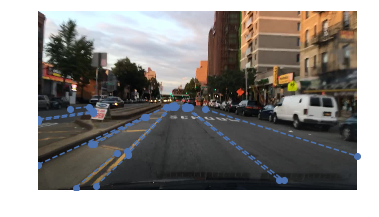

In [6]:
img = cv2.imread('/home/maharshi.t25/val/b1c66a42-6f7d68ca.jpg')[:,:,::-1]
plt.imshow(img)
plt.axis('off')

x=list()
y=list()
for i,j in enumerate(det_val['b1c66a42-6f7d68ca.jpg']):
#     print('Image_reading')
#     print(j)
    x=[]
    y=[]
    for k,l in enumerate(det_val['b1c66a42-6f7d68ca.jpg'][0]):
#         print('Points_extraction')
#         print(det_val['b1c66a42-6f7d68ca.jpg'][i][k])
        x.append(det_val['b1c66a42-6f7d68ca.jpg'][i][k][0])
        y.append(det_val['b1c66a42-6f7d68ca.jpg'][i][k][1])
    plt.plot(x, y, '--bo')

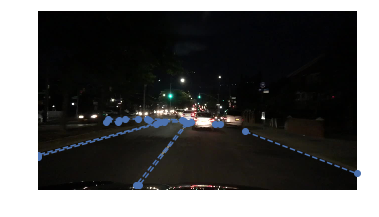

In [7]:
img = cv2.imread('/home/maharshi.t25/val/b1cd1e94-26dd524f.jpg')[:,:,::-1]
plt.imshow(img)
plt.axis('off')

x=list()
y=list()
for i,j in enumerate(det_val['b1cd1e94-26dd524f.jpg']):
#     print('Image_reading')
#     print(j)
    x=[]
    y=[]
    for k,l in enumerate(det_val['b1cd1e94-26dd524f.jpg'][0]):
#         print('Points_extraction')
#         print(det_val['b1cd1e94-26dd524f.jpg'][i][k])
        x.append(det_val['b1cd1e94-26dd524f.jpg'][i][k][0])
        y.append(det_val['b1cd1e94-26dd524f.jpg'][i][k][1])
    plt.plot(x, y, '--bo')

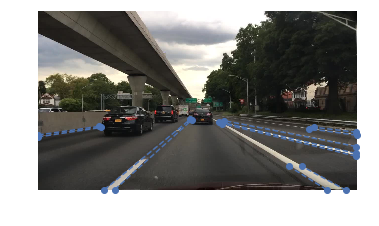

In [8]:
img = cv2.imread('/home/maharshi.t25/val/b1d0091f-75824d0d.jpg')[:,:,::-1]
plt.imshow(img)
plt.axis('off')

x=list()
y=list()
for i,j in enumerate(det_val['b1d0091f-75824d0d.jpg']):
#     print('Image_reading')
#     print(j)
    x=[]
    y=[]
    for k,l in enumerate(det_val['b1d0091f-75824d0d.jpg'][0]):
#         print('Points_extraction')
#         print(det_val['b1d0091f-75824d0d.jpg'][i][k])
        x.append(det_val['b1d0091f-75824d0d.jpg'][i][k][0])
        y.append(det_val['b1d0091f-75824d0d.jpg'][i][k][1])
    plt.plot(x, y, '--bo')

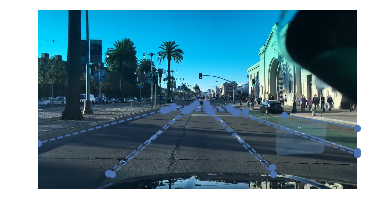

In [9]:
img = cv2.imread('/home/maharshi.t25/val/b4542860-0b880bb4.jpg')[:,:,::-1]
plt.imshow(img)
plt.axis('off')

x=list()
y=list()
for i,j in enumerate(det_val['b4542860-0b880bb4.jpg']):
#     print('Image_reading')
#     print(j)
    x=[]
    y=[]
    for k,l in enumerate(det_val['b4542860-0b880bb4.jpg'][0]):
#         print('Points_extraction')
#         print(det_val['b1d0091f-75824d0d.jpg'][i][k])
        x.append(det_val['b4542860-0b880bb4.jpg'][i][k][0])
        y.append(det_val['b4542860-0b880bb4.jpg'][i][k][1])
    plt.plot(x, y, '--bo')

## Data Splitting and Mask generation

In [10]:
# Looking at the images

In [11]:
pwd

'/jet/prs/workspace/Maharshi_Assignment3'

In [12]:
jpg_train=glob.glob("/home/maharshi.t25/val/*.jpg")
# jpg_train

In [13]:
# Fetching the names of the image
fig_name=list()
for i,j in enumerate(det_val):
    fig_name.append(j)

In [147]:
# Making mask from the point labels
s=np.linspace(0.0,1.0,1750)

# Morpholigical Dilation
kernel = np.ones((3,3),np.uint8)

for filename in fig_name:
    mask_img=np.zeros((720,1280), dtype=int)
    for i,j in enumerate(det_val[filename]):
        x=list() 
        y=list()
        for k,l in enumerate(det_val[filename][i]):
            x.append(det_val[filename][i][k][0])
            y.append(det_val[filename][i][k][1])
        xy=np.concatenate((np.asarray(x),np.asarray(y)), axis=0).reshape(2,len(x))
        curve1=bezier.Curve(xy, degree=4)
        points=curve1.evaluate_multi(s)
        
        try:
            mask_img[points[1,:].astype(int), points[0,:].astype(int)]=1
        except:
            mask_img[points[1,:].astype(int)-1, points[0,:].astype(int)-1]=1 
    mask_img = cv2.dilate(mask_img.astype('uint8'),kernel,iterations = 5)
    cv2.imwrite("/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask_data/"+filename+".png", mask_img)

In [14]:
jpg_val=glob.glob("/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask_data/*.png")
# jpg_val

In [15]:
print('Number of raw images')
print(len(jpg_train))
print('Number of mask images')
print(len(jpg_val))

Number of raw images
10000
Number of mask images
10000


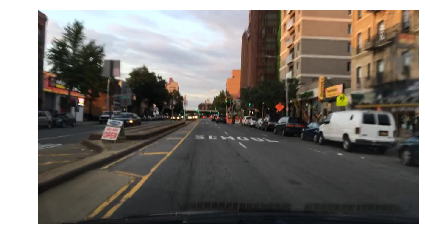

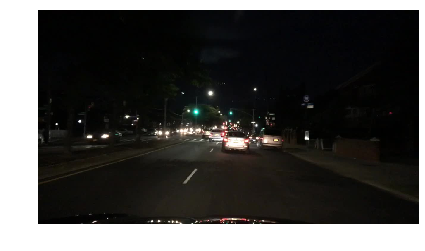

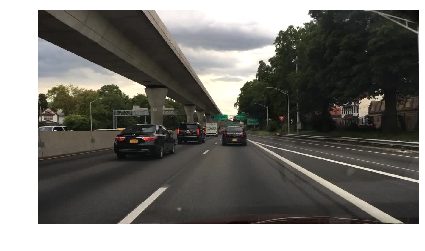

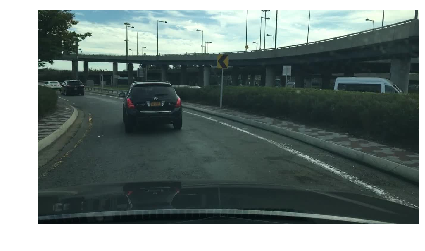

In [19]:
# Raw image

plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
img=cv2.imread(jpg_train[jpg_train.index('/home/maharshi.t25/val/'+'b1c66a42-6f7d68ca.jpg')])[:,:,::-1]
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(2,2,2)
img=cv2.imread(jpg_train[jpg_train.index('/home/maharshi.t25/val/'+'b1cd1e94-26dd524f.jpg')])[:,:,::-1]
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(2,2,3)
img=cv2.imread(jpg_train[jpg_train.index('/home/maharshi.t25/val/'+'b1d0091f-75824d0d.jpg')])[:,:,::-1]
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(2,2,4)
img=cv2.imread(jpg_train[jpg_train.index('/home/maharshi.t25/val/'+'b6b0d831-7abd7933.jpg')])[:,:,::-1]
plt.imshow(img)
plt.axis('off')
plt.show()

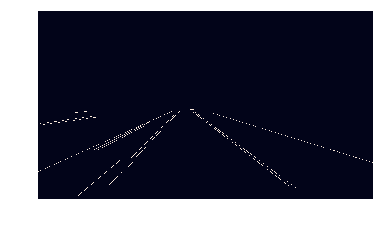

In [31]:
# What if dilation was not applied? - Image 1

# Making mask from the point labels
s=np.linspace(0.0,1.0,1750)

filename='b1c66a42-6f7d68ca.jpg'
mask_img=np.zeros((720,1280), dtype=int)
x=list() 
y=list()

for i,j in enumerate(det_val[filename]):
    x=list() 
    y=list()
    for k,l in enumerate(det_val[filename][i]):
        x.append(det_val[filename][i][k][0])
        y.append(det_val[filename][i][k][1])
    xy=np.concatenate((np.asarray(x),np.asarray(y)), axis=0).reshape(2,len(x))
    curve1=bezier.Curve(xy, degree=4)
    points=curve1.evaluate_multi(s)
        
    try:
        mask_img[points[1,:].astype(int), points[0,:].astype(int)]=1
    except:
        mask_img[points[1,:].astype(int)-1, points[0,:].astype(int)-1]=1 
    
plt.imshow(mask_img)
plt.axis('off')
plt.show()

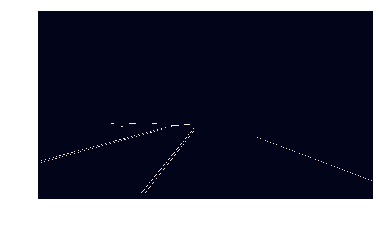

In [32]:
# What if dilation was not applied? - Image 2

# Making mask from the point labels
s=np.linspace(0.0,1.0,1750)

filename='b1cd1e94-26dd524f.jpg'
mask_img=np.zeros((720,1280), dtype=int)
x=list() 
y=list()

for i,j in enumerate(det_val[filename]):
    x=list() 
    y=list()
    for k,l in enumerate(det_val[filename][i]):
        x.append(det_val[filename][i][k][0])
        y.append(det_val[filename][i][k][1])
    xy=np.concatenate((np.asarray(x),np.asarray(y)), axis=0).reshape(2,len(x))
    curve1=bezier.Curve(xy, degree=4)
    points=curve1.evaluate_multi(s)
        
    try:
        mask_img[points[1,:].astype(int), points[0,:].astype(int)]=1
    except:
        mask_img[points[1,:].astype(int)-1, points[0,:].astype(int)-1]=1 
    
plt.imshow(mask_img)
plt.axis('off')
plt.show()

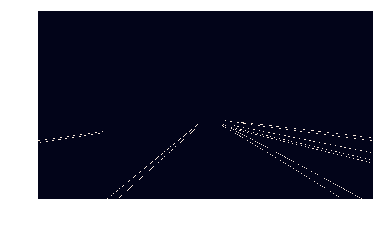

In [33]:
# What if dilation was not applied? - Image 3

# Making mask from the point labels
s=np.linspace(0.0,1.0,1750)

filename='b1d0091f-75824d0d.jpg'
mask_img=np.zeros((720,1280), dtype=int)
x=list() 
y=list()

for i,j in enumerate(det_val[filename]):
    x=list() 
    y=list()
    for k,l in enumerate(det_val[filename][i]):
        x.append(det_val[filename][i][k][0])
        y.append(det_val[filename][i][k][1])
    xy=np.concatenate((np.asarray(x),np.asarray(y)), axis=0).reshape(2,len(x))
    curve1=bezier.Curve(xy, degree=4)
    points=curve1.evaluate_multi(s)
        
    try:
        mask_img[points[1,:].astype(int), points[0,:].astype(int)]=1
    except:
        mask_img[points[1,:].astype(int)-1, points[0,:].astype(int)-1]=1 
    
plt.imshow(mask_img)
plt.axis('off')
plt.show()

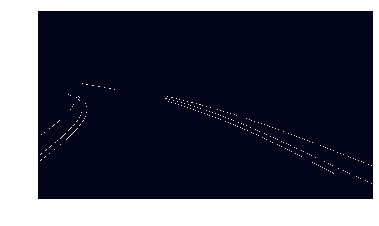

In [34]:
# What if dilation was not applied? - Image 4

# Making mask from the point labels
s=np.linspace(0.0,1.0,1750)

filename='b6b0d831-7abd7933.jpg'
mask_img=np.zeros((720,1280), dtype=int)
x=list() 
y=list()

for i,j in enumerate(det_val[filename]):
    x=list() 
    y=list()
    for k,l in enumerate(det_val[filename][i]):
        x.append(det_val[filename][i][k][0])
        y.append(det_val[filename][i][k][1])
    xy=np.concatenate((np.asarray(x),np.asarray(y)), axis=0).reshape(2,len(x))
    curve1=bezier.Curve(xy, degree=4)
    points=curve1.evaluate_multi(s)
        
    try:
        mask_img[points[1,:].astype(int), points[0,:].astype(int)]=1
    except:
        mask_img[points[1,:].astype(int)-1, points[0,:].astype(int)-1]=1 
    
plt.imshow(mask_img)
plt.axis('off')
plt.show()

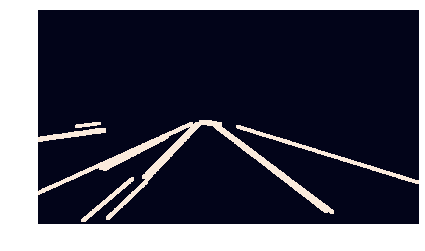

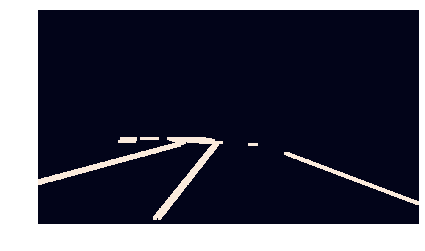

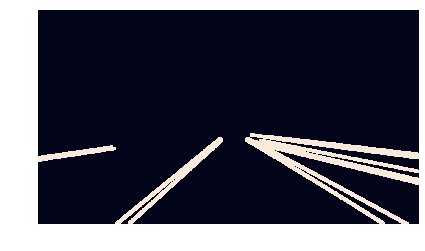

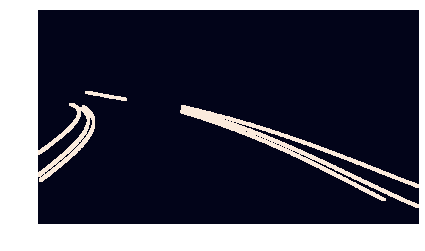

In [21]:
# 1st mask - Lane (or foreground)

str1='/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask_data/'
str3='.png'
plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
img=cv2.imread(str1+'b1c66a42-6f7d68ca.jpg'+str3)[:,:,0]
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(2,2,2)
img=cv2.imread(str1+'b1cd1e94-26dd524f.jpg'+str3)[:,:,0]
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(2,2,3)
img=cv2.imread(str1+'b1d0091f-75824d0d.jpg'+str3)[:,:,0]
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(2,2,3)
img=cv2.imread(str1+'b6b0d831-7abd7933.jpg'+str3)[:,:,0]
plt.imshow(img)
plt.axis('off')
plt.show()

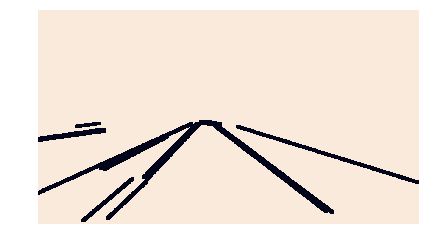

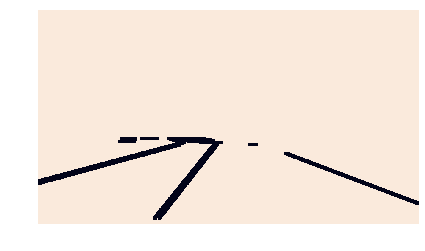

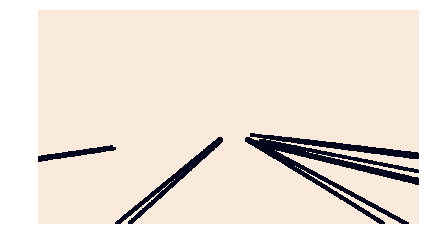

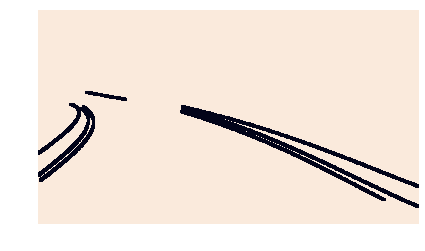

In [23]:
# 2nd mask - background

str1='/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask_data/'
str3='.png'
plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
img=cv2.imread(str1+'b1c66a42-6f7d68ca.jpg'+str3)[:,:,0]
plt.imshow(1-img)
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(2,2,2)
img=cv2.imread(str1+'b1cd1e94-26dd524f.jpg'+str3)[:,:,0]
plt.imshow(1-img)
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(2,2,3)
img=cv2.imread(str1+'b1d0091f-75824d0d.jpg'+str3)[:,:,0]
plt.imshow(1-img)
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(2,2,4)
img=cv2.imread(str1+'b6b0d831-7abd7933.jpg'+str3)[:,:,0]
plt.imshow(1-img)
plt.axis('off')
plt.show()

In [24]:
#Proper arrangement of the list
jpg_train_updated=list()
for i,j in enumerate(jpg_val):
    jpg_train_updated.append(jpg_train[jpg_train.index('/home/maharshi.t25/val/'+j[64:-8]+'.jpg')])

In [26]:
jpg_train_updated[0]

'/home/maharshi.t25/val/c7eddd1b-73993ae6.jpg'

In [27]:
jpg_val[0]

'/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask_data/c7eddd1b-73993ae6.jpg.png'

In [28]:
#Checking whether the list is shuffled properly or not
"""
1 represents that they are same and 0 represents that they are different in order
"""
count=0
for i,j in enumerate(jpg_val):
    count=((j[64:-8]==jpg_train_updated[i][23:-4])*1)+count

if count == 10000:
    print("List sequence is properly arranged")
else:
    print("Please arranged it properly")

List sequence is properly arranged


In [29]:
#Splitting the data into Train, Validation and Test set
from sklearn.model_selection import train_test_split
raw_img_names=np.array(jpg_train_updated)
mask_img_names=np.array(jpg_val)
# Train split
raw_img_name_tr,raw_img_name_1,mask_img_name_tr,mask_img_name_1 = train_test_split(raw_img_names,mask_img_names,
                                                                                     shuffle=True,test_size=0.30)
# Validation - Test split
raw_img_name_val,raw_img_name_te,mask_img_name_val,mask_img_name_te = train_test_split(raw_img_name_1,mask_img_name_1,
                                                                                     shuffle=True,test_size=0.50)

In [30]:
# Dataset size after splitting
print('Number of raw images for training')
print(raw_img_name_tr.shape)
print('Number of mask images for training')
print(mask_img_name_tr.shape)

print('Number of raw images for validation')
print(raw_img_name_val.shape)
print('Number of mask images for validation')
print(mask_img_name_val.shape)

print('Number of raw images for testing')
print(raw_img_name_te.shape)
print('Number of mask images for testing')
print(mask_img_name_te.shape)

Number of raw images for training
(7000,)
Number of mask images for training
(7000,)
Number of raw images for validation
(1500,)
Number of mask images for validation
(1500,)
Number of raw images for testing
(1500,)
Number of mask images for testing
(1500,)


In [31]:
print(raw_img_name_tr[0])
print(mask_img_name_tr[0])

print(raw_img_name_val[0])
print(mask_img_name_val[0])

print(raw_img_name_te[0])
print(mask_img_name_te[0])

/home/maharshi.t25/val/bc223780-c88ddd93.jpg
/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask_data/bc223780-c88ddd93.jpg.png
/home/maharshi.t25/val/b4eee282-a7157230.jpg
/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask_data/b4eee282-a7157230.jpg.png
/home/maharshi.t25/val/ca0eb18c-b0e6fe6c.jpg
/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask_data/ca0eb18c-b0e6fe6c.jpg.png


In [32]:
pwd

'/jet/prs/workspace/Maharshi_Assignment3'

In [33]:
mask_img_name_tr[0][64:-8]

'bc223780-c88ddd93'

In [34]:
raw_img_name_tr[0][23:-4]

'bc223780-c88ddd93'

Some images in which lanes are in curvateure.

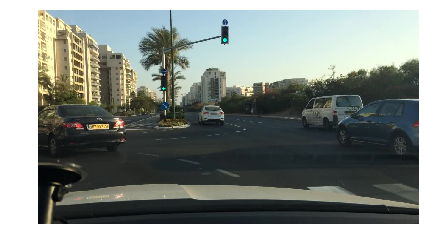

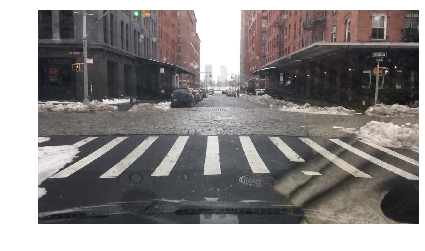

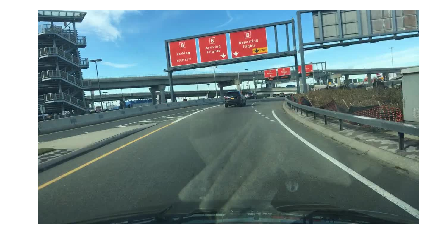

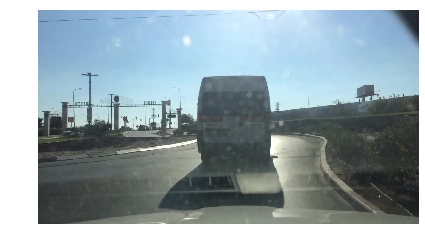

In [22]:
plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
img=cv2.imread(jpg_train[jpg_train.index('/home/maharshi.t25/val/'+'b2a5baf7-58519386.jpg')])[:,:,::-1]
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(2,2,2)
img=cv2.imread(jpg_train[jpg_train.index('/home/maharshi.t25/val/'+'b1d0a191-5490450b.jpg')])[:,:,::-1]
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(2,2,3)
img=cv2.imread(jpg_train[jpg_train.index('/home/maharshi.t25/val/'+'b2d22b2f-91d0af18.jpg')])[:,:,::-1]
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(2,2,4)
img=cv2.imread(jpg_train[jpg_train.index('/home/maharshi.t25/val/'+'b1d7b3ac-5af8623b.jpg')])[:,:,::-1]
plt.imshow(img)
plt.axis('off')
plt.show()

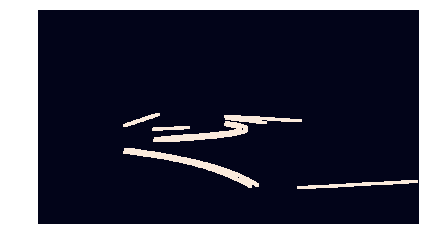

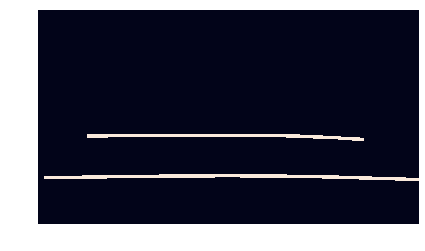

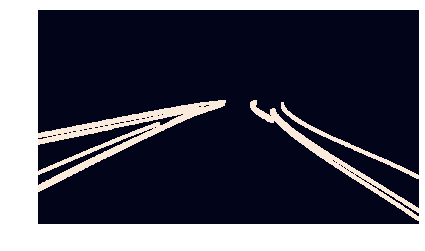

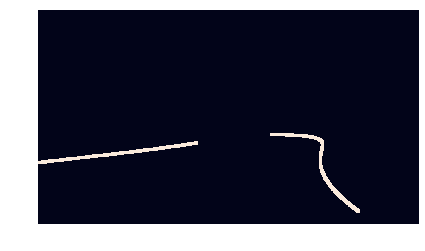

In [23]:
str1='/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask_data/'
str3='.png'
plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
img=cv2.imread(str1+'b2a5baf7-58519386.jpg'+str3)[:,:,0]
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(2,2,2)
img=cv2.imread(str1+'b1d0a191-5490450b.jpg'+str3)[:,:,0]
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(2,2,3)
img=cv2.imread(str1+'b2d22b2f-91d0af18.jpg'+str3)[:,:,0]
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(2,2,4)
img=cv2.imread(str1+'b1d7b3ac-5af8623b.jpg'+str3)[:,:,0]
plt.imshow(img)
plt.axis('off')
plt.show()

# Run next two cells only if necessary - It may delete the existing split of the data

In [164]:
# Remove existing directory, named data
try:
    shutil.rmtree('data')
except:
    print('It has been already removed.')

In [165]:
# Generating directories for Train, Validation and Test - Raw and Mask image data

if not os.path.exists('data'):
    os.makedirs('data')
    
if not os.path.exists('data/train'):
    os.makedirs('data/train')
    os.makedirs('data/train/raw')
    os.makedirs('data/train/mask')
    
if not os.path.exists('data/validation'):
    os.makedirs('data/validation')
    os.makedirs('data/validation/raw')
    os.makedirs('data/validation/mask')

if not os.path.exists('data/test'):
    os.makedirs('data/test')
    os.makedirs('data/test/raw')
    os.makedirs('data/test/mask')

# Reading training images and making a folder for the same the model
raw_img=0
mask_img=0

for i,j in enumerate(mask_img_name_tr):
    
    if j[64:-8] == raw_img_name_tr[i][23:-4]:
        
        raw_img=cv2.imread(raw_img_name_tr[i])[:,:,::-1]
        raw_img=cv2.resize(raw_img,dsize=(256,256),interpolation=cv2.INTER_NEAREST)
        
        mask_img=cv2.imread(j)
        mask_img=cv2.resize(mask_img,dsize=(256,256),interpolation=cv2.INTER_NEAREST)
        
        cv2.imwrite('data/train/raw/'+j[64:-8]+'.png',raw_img)
        cv2.imwrite('data/train/mask/'+j[64:-8]+'.png',mask_img)
        
        raw_img=0
        mask_img=0

# Reading validation images and making a folder for the same the model
raw_img=0
mask_img=0

for i,j in enumerate(mask_img_name_val):
    
    if j[64:-8] == raw_img_name_val[i][23:-4]:
        
        raw_img=cv2.imread(raw_img_name_val[i])[:,:,::-1]
        raw_img=cv2.resize(raw_img,dsize=(256,256),interpolation=cv2.INTER_NEAREST)
        
        mask_img=cv2.imread(j)
        mask_img=cv2.resize(mask_img,dsize=(256,256),interpolation=cv2.INTER_NEAREST)
        
        cv2.imwrite('data/validation/raw/'+j[64:-8]+'.png',raw_img)
        cv2.imwrite('data/validation/mask/'+j[64:-8]+'.png',mask_img)
        
        raw_img=0
        mask_img=0
        
# Reading testing images and making a folder for the same the model
raw_img=0
mask_img=0

for i,j in enumerate(mask_img_name_te):
    
    if j[64:-8] == raw_img_name_te[i][23:-4]:
        
        raw_img=cv2.imread(raw_img_name_te[i])[:,:,::-1]
        raw_img=cv2.resize(raw_img,dsize=(256,256),interpolation=cv2.INTER_NEAREST)
        
        mask_img=cv2.imread(j)
        mask_img=cv2.resize(mask_img,dsize=(256,256),interpolation=cv2.INTER_NEAREST)
        
        cv2.imwrite('data/test/raw/'+j[64:-8]+'.png',raw_img)
        cv2.imwrite('data/test/mask/'+j[64:-8]+'.png',mask_img)
        
        raw_img=0
        mask_img=0

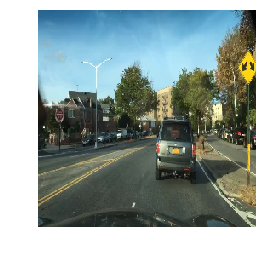

In [74]:
I=cv2.imread(glob.glob("data/train/raw/*.png")[600])
plt.axis('off')
plt.imshow(I)

In [75]:
I.shape

(256, 256, 3)

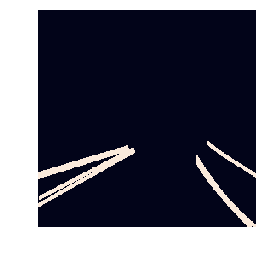

In [77]:
I=cv2.imread(glob.glob("data/train/mask/*.png")[600])[:,:,0]
plt.axis('off')
plt.imshow(I)

In [16]:
list1=glob.glob("data/train/raw/*.png")
list2=glob.glob("data/train/mask/*.png")

In [78]:
list2[0][16:]

'c4d25f00-3b1d8669.png'

In [80]:
list1[0][15:]

'c4d25f00-3b1d8669.png'

In [85]:
list2[0][16:]==list1[0][15:]

True

In [87]:
list1=glob.glob("data/validation/raw/*.png")
list2=glob.glob("data/validation/mask/*.png")

In [90]:
list1[0][20:]

'c38bdba6-181f8cfa.png'

In [92]:
list2[0][21:]

'c38bdba6-181f8cfa.png'

In [93]:
list2[0][21:]==list1[0][20:]

True

In [94]:
list1=glob.glob("data/test/raw/*.png")
list2=glob.glob("data/test/mask/*.png")

In [99]:
list2[0][15:]

'b605d5d8-ec6fab2b.png'

In [102]:
list1[0][14:]

'b605d5d8-ec6fab2b.png'

In [103]:
list2[0][15:]==list1[0][14:]

True

## Data Generator and Data-driven model training

- Data generator generated batch of training images and its mask and supplies those batches to the network for training.
- It generates two masks one for the road and one for the background.
- Training and Validation generators are mentioned below.

In [26]:
def custom_data_generator(image_path,mask_path,n_batches):
    
    img_batch=np.zeros((n_batches,256,256,3))
    mask_batch=np.zeros((n_batches,256,256,2))
    raw_files=np.array(os.listdir(image_path))

    while True:
  
        batch_paths=np.random.choice(raw_files,n_batches)

        for i,j in enumerate(batch_paths):
            
            temp_mask=np.ones((256,256))
        
            img_batch[i,:,:,:]=((cv2.imread(image_path+j)).astype(np.float32))/255.0
            mask_batch[i,:,:,1]=(cv2.imread(mask_path+j)[:,:,0]).astype(np.float32)
            
            temp_mask=1.0-mask_batch[i,:,:,1]
            mask_batch[i,:,:,0]=temp_mask.astype(np.float32)
            
        yield (img_batch.astype(np.float32),mask_batch.astype(np.float32))

In [27]:
generator_object=custom_data_generator("data/train/raw/","data/train/mask/",1)

In [81]:
b,c=next(generator_object)

In [82]:
b.shape

(1, 256, 256, 3)

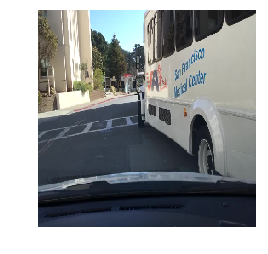

In [83]:
plt.axis('off')
plt.imshow(b[0])

In [84]:
c.shape

(1, 256, 256, 2)

Cream/White pixels in the following image refers to the background and those pixels have intensity value equals to one.

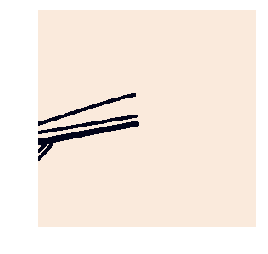

In [85]:
plt.axis('off')
plt.imshow(np.squeeze(c[0][:,:,0]))

White pixels in the following image refers to the lane markings and those pixels have intensity value equals to one.

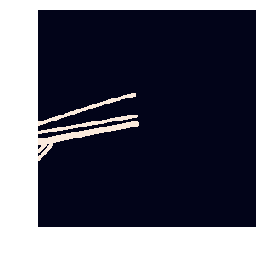

In [86]:
plt.axis('off')
plt.imshow(np.squeeze(c[0][:,:,1]))

In [88]:
def custom_valid_data_generator(val_image_path,val_mask_path,n_batches):
    
    val_img_batch=np.zeros((n_batches,256,256,3))
    val_mask_batch=np.zeros((n_batches,256,256,2))
    raw_files=np.array(os.listdir(val_image_path))

    while True:
  
        batch_paths=np.random.choice(raw_files,n_batches)


        for i,j in enumerate(batch_paths):
            
            temp_mask=np.ones((256,256))
        
            val_img_batch[i,:,:,:]=((cv2.imread(val_image_path+j)).astype(np.float32))/255.0
            val_mask_batch[i,:,:,1]=cv2.imread(val_mask_path+j)[:,:,0].astype(np.float32)
            
            temp_mask=1.0-val_mask_batch[i,:,:,1]
            val_mask_batch[i,:,:,0]=temp_mask.astype(np.float32)
            
        yield (val_img_batch.astype(np.float32),val_mask_batch.astype(np.float32))

In [89]:
valid_generator_object=custom_valid_data_generator("data/validation/raw/","data/validation/mask/",1)

In [90]:
d,e=next(valid_generator_object)

In [91]:
d.shape

(1, 256, 256, 3)

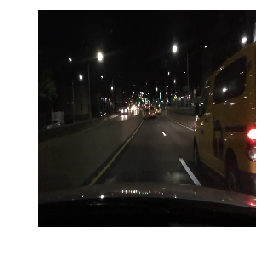

In [92]:
plt.axis('off')
plt.imshow(d[0])

In [93]:
e.shape

(1, 256, 256, 2)

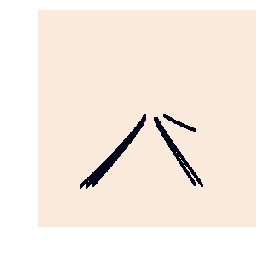

In [94]:
# Original mask
plt.axis('off')
plt.imshow(np.squeeze(e[0][:,:,0]))

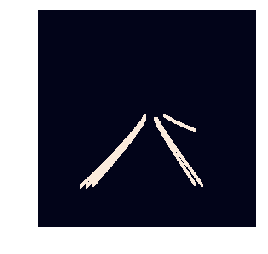

In [95]:
# Reverse mask
plt.axis('off')
plt.imshow(np.squeeze(e[0][:,:,1]))

# Keras model for UNet

In [21]:
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Deconvolution2D, Cropping2D, Conv2DTranspose, UpSampling2D
from keras.layers import Input, Add, Dropout, Permute, add, concatenate, Reshape, Activation,BatchNormalization
from scipy.io import loadmat
from keras import backend as K
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import load_model

In [17]:
def Unet (img_width , img_height, n_classes): 

    inputs = Input((img_width, img_height,3))
    
    kernel_initializer="he_normal"
    padding='same'
    activation='relu'
    
    conv1 = Convolution2D(64, (3, 3), activation=activation,padding=padding, kernel_initializer=kernel_initializer, name='conv1_blck1')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Convolution2D(64, (3, 3), activation=activation ,padding=padding,kernel_initializer=kernel_initializer, name='block1_conv2')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.2)(pool1)

    conv2 = Convolution2D(128, (3, 3), activation=activation,padding=padding,kernel_initializer=kernel_initializer, name='block2_conv1')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Convolution2D(128, (3, 3), activation=activation,padding=padding, kernel_initializer=kernel_initializer,name='block2_conv2')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.2)(pool2)

    conv3 = Convolution2D(256, (3, 3), activation=activation,padding=padding, kernel_initializer=kernel_initializer,name='block3_conv1')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Convolution2D(256, (3, 3), activation=activation,padding=padding, kernel_initializer=kernel_initializer,name='block3_conv2')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.2)(pool3)

    conv4 = Convolution2D(512, (3, 3), activation=activation,padding=padding,kernel_initializer=kernel_initializer, name='block4_conv1')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Convolution2D(512, (3, 3), activation=activation,padding=padding, kernel_initializer=kernel_initializer,name='block4_conv2')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.2)(pool4)

    conv5 = Convolution2D(1024, (3, 3), activation=activation,padding=padding,kernel_initializer=kernel_initializer, name='block5_conv1')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Convolution2D(1024, (3, 3), activation=activation,padding=padding,kernel_initializer=kernel_initializer, name='block5_conv2')(conv5)
    conv5 = BatchNormalization()(conv5)

    
    up1 = (UpSampling2D( (2,2)))(conv5)
    upconv1 = Convolution2D(512, (3, 3), padding=padding, name='upblock1_conv1', data_format='channels_last')(up1)
    add1 = ( concatenate([ conv4 ,upconv1],axis=3 )  )
    add1 = Dropout(0.2)(add1)
    conv6 = Convolution2D(512, (3, 3), activation=activation, padding=padding,kernel_initializer=kernel_initializer, name='upblock1_conv2')(add1)
    conv6 = BatchNormalization()(conv6)
    conv6 = Convolution2D(512, (3, 3), activation=activation, padding=padding ,kernel_initializer=kernel_initializer,name='upblock1_conv3')(conv6)
    conv6 = BatchNormalization()(conv6)

    
    up2 = (UpSampling2D( (2,2)))(conv6)
    upconv2 = Convolution2D(256, (3, 3), padding=padding, name='upblock2_conv1')(up2)
    add2 = ( concatenate([ conv3 ,upconv2],axis=3 )  )
    add2 = Dropout(0.2)(add2)
    conv7 = Convolution2D(256, (3, 3), activation=activation, padding=padding, kernel_initializer=kernel_initializer,name='upblock2_conv2')(add2)
    conv7 = BatchNormalization()(conv7)
    conv7 = Convolution2D(256, (3, 3), activation=activation, padding=padding ,kernel_initializer=kernel_initializer,name='upblock2_conv3')(conv7)
    conv7 = BatchNormalization()(conv7)

    up3 = (UpSampling2D( (2,2)))(conv7)
    upconv3 = Convolution2D(128, (3, 3), padding=padding, name='upblock3_conv1')(up3)
    add3 = ( concatenate([ conv2 ,upconv3],axis=3 )  )
    add3 = Dropout(0.2)(add3)
    conv8 = Convolution2D(128, (3, 3), activation=activation, padding=padding, kernel_initializer=kernel_initializer,name='upblock3_conv2')(add3)
    conv8 = BatchNormalization()(conv8)
    conv8 = Convolution2D(128, (3, 3), activation=activation, padding=padding ,kernel_initializer=kernel_initializer,name='upblock3_conv3')(conv8)
    conv8 = BatchNormalization()(conv8)

    up4 = (UpSampling2D( (2,2)))(conv8)
    upconv4 = Convolution2D(64, (3, 3), padding=padding, name='upblock4_conv1')(up4)
    add4 = ( concatenate([ conv1 ,upconv4],axis=3 )  )
    add4 = Dropout(0.2)(add4)
    conv9 = Convolution2D(64, (3, 3), activation=activation, padding=padding, kernel_initializer=kernel_initializer,name='upblock4_conv2')(add4)
    conv9 = BatchNormalization()(conv9)
    conv9 = Convolution2D(64, (3, 3), activation=activation, padding=padding ,kernel_initializer=kernel_initializer,name='upblock4_conv3')(conv9)
    conv9 = BatchNormalization()(conv9)

    o =  Convolution2D( n_classes , (3, 3) , padding=padding)( conv9 )

    o = (Activation('softmax'))(o)
    model = Model( inputs , o )
    
    return model

In [18]:
from keras.optimizers import Adam, RMSprop 
from keras.metrics import binary_crossentropy,categorical_crossentropy

model = Unet(256,256,2) 
model.compile(loss='categorical_crossentropy', optimizer= Adam(lr=.001) , metrics=['accuracy'] )

In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_blck1 (Conv2D)            (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         conv1_blck1[0][0]                
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [5]:
def iou(y_true,y_pred):
    
    num=1.0
    den=1.0
    intersection1=1.0
    
    intersection=np.multiply(y_true, y_pred)
    num=np.where(intersection==1)[0].shape[0]
    den=np.where(y_true==1)[0].shape[0] + np.where(y_pred==1)[0].shape[0]-num   
    
    try:
        io=(num/den)
    except:
        io=0.0
    
    return io

In [6]:
# Training data IoU

def mean_iou(model,filepath,maskpath):
    # Training data IoU
    tr_raw=os.listdir(filepath)
    num_iou=0.0
    for i in tr_raw:

        img=cv2.imread(filepath+i)
        img=(img/255.).astype(np.float32)
        pred_mask2=model.predict(img[np.newaxis,:,:,:])[0].argmax(axis=2) #Road
        pred_mask1=1.0 - pred_mask2 #Background

        actual_mask=cv2.imread(maskpath+i)
        actual_mask2=actual_mask[:,:,0] #Road
        actual_mask2=actual_mask2.astype(np.float32)
        actual_mask1=1.0 - actual_mask2 #Background

        iou_fn1=iou(actual_mask1.astype(np.float32),pred_mask1.astype(np.float32))
        iou_fn2=iou(actual_mask2.astype(np.float32),pred_mask2.astype(np.float32))
        num_iou=num_iou + ((iou_fn1 + iou_fn2)/2)

    mean_iou=num_iou/len(tr_raw)
    
    return mean_iou

In [345]:
history1=model.fit_generator(generator=generator_object,steps_per_epoch=7000,
                             epochs=1,validation_data=valid_generator_object,validation_steps=1500)

model.save('lane_detector_model_UNet_1epochs_try_softmax1903.h5')

Epoch 1/1
7000/7000 [==============================] - 651s 93ms/step - loss: 0.0887 - acc: 0.9715 - val_loss: 0.0780 - val_acc: 0.9742


In [346]:
training_miou=dict()
validation_miou=dict()
training_miou['1']=mean_iou(model,'data/train/raw/','data/train/mask/')
validation_miou['1']=mean_iou(model,'data/validation/raw/','data/validation/mask/')

In [347]:
training_miou['1']

0.6194742239083368

In [348]:
validation_miou['1']

0.6187581110063134

In [349]:
history2=model.fit_generator(generator=generator_object,steps_per_epoch=7000,
                             epochs=1,validation_data=valid_generator_object,validation_steps=1500)

model.save('lane_detector_model_UNet_1+1epochs_try_softmax1903.h5')

Epoch 1/1
7000/7000 [==============================] - 629s 90ms/step - loss: 0.0651 - acc: 0.9769 - val_loss: 0.0746 - val_acc: 0.9735


In [350]:
training_miou['2']=mean_iou(model,'data/train/raw/','data/train/mask/')
validation_miou['2']=mean_iou(model,'data/validation/raw/','data/validation/mask/')

In [351]:
history3=model.fit_generator(generator=generator_object,steps_per_epoch=7000,
                             epochs=1,validation_data=valid_generator_object,validation_steps=1500)

model.save('lane_detector_model_UNet_1+1+1epochs_try_softmax1903.h5')

Epoch 1/1
7000/7000 [==============================] - 629s 90ms/step - loss: 0.0582 - acc: 0.9785 - val_loss: 0.0632 - val_acc: 0.9783


In [352]:
training_miou['3']=mean_iou(model,'data/train/raw/','data/train/mask/')
validation_miou['3']=mean_iou(model,'data/validation/raw/','data/validation/mask/')

In [353]:
history4=model.fit_generator(generator=generator_object,steps_per_epoch=7000,
                             epochs=1,validation_data=valid_generator_object,validation_steps=1500)

model.save('lane_detector_model_UNet_1+1+1+1epochs_try_softmax1903.h5')

Epoch 1/1
7000/7000 [==============================] - 629s 90ms/step - loss: 0.0532 - acc: 0.9799 - val_loss: 0.0680 - val_acc: 0.9776


In [354]:
training_miou['4']=mean_iou(model,'data/train/raw/','data/train/mask/')
validation_miou['4']=mean_iou(model,'data/validation/raw/','data/validation/mask/')

In [355]:
history5=model.fit_generator(generator=generator_object,steps_per_epoch=7000,
                             epochs=1,validation_data=valid_generator_object,validation_steps=1500)

model.save('lane_detector_model_UNet_1+1+1+1+1epochs_try_softmax1903.h5')

Epoch 1/1
7000/7000 [==============================] - 630s 90ms/step - loss: 0.0498 - acc: 0.9810 - val_loss: 0.0761 - val_acc: 0.9789


In [356]:
training_miou['5']=mean_iou(model,'data/train/raw/','data/train/mask/')
validation_miou['5']=mean_iou(model,'data/validation/raw/','data/validation/mask/')

In [357]:
history6=model.fit_generator(generator=generator_object,steps_per_epoch=7000,
                             epochs=1,validation_data=valid_generator_object,validation_steps=1500)

model.save('lane_detector_model_UNet_1+1+1+1+1+1epochs_try_softmax1903.h5')

Epoch 1/1
7000/7000 [==============================] - 629s 90ms/step - loss: 0.0467 - acc: 0.9820 - val_loss: 0.0622 - val_acc: 0.9798


In [358]:
training_miou['6']=mean_iou(model,'data/train/raw/','data/train/mask/')
validation_miou['6']=mean_iou(model,'data/validation/raw/','data/validation/mask/')

In [24]:
history7=model.fit_generator(generator=generator_object,steps_per_epoch=7000,
                             epochs=1,validation_data=valid_generator_object,validation_steps=1500)

model.save('lane_detector_model_UNet_1+1+1+1+1+1+1epochs_try_softmax1903.h5')

Epoch 1/1
7000/7000 [==============================] - 600s 86ms/step - loss: 0.0444 - acc: 0.9825 - val_loss: 0.0632 - val_acc: 0.9794


In [27]:
# Saved from 7th
training_miou['7']=mean_iou(model,'data/train/raw/','data/train/mask/')
validation_miou['7']=mean_iou(model,'data/validation/raw/','data/validation/mask/')

In [28]:
history8=model.fit_generator(generator=generator_object,steps_per_epoch=7000,
                             epochs=1,validation_data=valid_generator_object,validation_steps=1500)

model.save('lane_detector_model_UNet_1+1+1+1+1+1+1+1epochs_try_softmax1903.h5')

Epoch 1/1
7000/7000 [==============================] - 597s 85ms/step - loss: 0.0426 - acc: 0.9831 - val_loss: 0.0869 - val_acc: 0.9796


In [29]:
training_miou['8']=mean_iou(model,'data/train/raw/','data/train/mask/')
validation_miou['8']=mean_iou(model,'data/validation/raw/','data/validation/mask/')

In [30]:
history9=model.fit_generator(generator=generator_object,steps_per_epoch=7000,
                             epochs=1,validation_data=valid_generator_object,validation_steps=1500)

model.save('lane_detector_model_UNet_1+1+1+1+1+1+1+1+1epochs_try_softmax1903.h5')

Epoch 1/1
7000/7000 [==============================] - 597s 85ms/step - loss: 0.0406 - acc: 0.9839 - val_loss: 0.0657 - val_acc: 0.9803


In [31]:
training_miou['9']=mean_iou(model,'data/train/raw/','data/train/mask/')
validation_miou['9']=mean_iou(model,'data/validation/raw/','data/validation/mask/')

In [32]:
history10=model.fit_generator(generator=generator_object,steps_per_epoch=7000,
                             epochs=1,validation_data=valid_generator_object,validation_steps=1500)

model.save('lane_detector_model_UNet_1+1+1+1+1+1+1+1+1+1epochs_try_softmax1903.h5')

Epoch 1/1
7000/7000 [==============================] - 597s 85ms/step - loss: 0.0398 - acc: 0.9841 - val_loss: 0.0640 - val_acc: 0.9802


In [33]:
training_miou['10']=mean_iou(model,'data/train/raw/','data/train/mask/')
validation_miou['10']=mean_iou(model,'data/validation/raw/','data/validation/mask/')

In [34]:
history11=model.fit_generator(generator=generator_object,steps_per_epoch=7000,
                             epochs=1,validation_data=valid_generator_object,validation_steps=1500)

model.save('lane_detector_model_UNet_1+1+1+1+1+1+1+1+1+1+1epochs_try_softmax1903.h5')

Epoch 1/1
7000/7000 [==============================] - 597s 85ms/step - loss: 0.0384 - acc: 0.9845 - val_loss: 0.0762 - val_acc: 0.9798


In [35]:
training_miou['11']=mean_iou(model,'data/train/raw/','data/train/mask/')
validation_miou['11']=mean_iou(model,'data/validation/raw/','data/validation/mask/')

In [36]:
history12=model.fit_generator(generator=generator_object,steps_per_epoch=7000,
                             epochs=1,validation_data=valid_generator_object,validation_steps=1500)

model.save('lane_detector_model_UNet_1+1+1+1+1+1+1+1+1+1+1+1epochs_try_softmax1903.h5')

Epoch 1/1
7000/7000 [==============================] - 597s 85ms/step - loss: 0.0364 - acc: 0.9852 - val_loss: 0.0724 - val_acc: 0.9811


In [37]:
training_miou['12']=mean_iou(model,'data/train/raw/','data/train/mask/')
validation_miou['12']=mean_iou(model,'data/validation/raw/','data/validation/mask/')

In [38]:
history13=model.fit_generator(generator=generator_object,steps_per_epoch=7000,
                             epochs=1,validation_data=valid_generator_object,validation_steps=1500)

model.save('lane_detector_model_UNet_1+1+1+1+1+1+1+1+1+1+1+1+1epochs_try_softmax1903.h5')

Epoch 1/1
7000/7000 [==============================] - 597s 85ms/step - loss: 0.0348 - acc: 0.9858 - val_loss: 0.0800 - val_acc: 0.9794


In [39]:
training_miou['13']=mean_iou(model,'data/train/raw/','data/train/mask/')
validation_miou['13']=mean_iou(model,'data/validation/raw/','data/validation/mask/')

In [40]:
history14=model.fit_generator(generator=generator_object,steps_per_epoch=7000,
                             epochs=1,validation_data=valid_generator_object,validation_steps=1500)

model.save('lane_detector_model_UNet_1+1+1+1+1+1+1+1+1+1+1+1+1+1epochs_try_softmax1903.h5')

Epoch 1/1
7000/7000 [==============================] - 597s 85ms/step - loss: 0.0346 - acc: 0.9857 - val_loss: 0.0654 - val_acc: 0.9809


In [41]:
training_miou['14']=mean_iou(model,'data/train/raw/','data/train/mask/')
validation_miou['14']=mean_iou(model,'data/validation/raw/','data/validation/mask/')

In [42]:
history15=model.fit_generator(generator=generator_object,steps_per_epoch=7000,
                             epochs=1,validation_data=valid_generator_object,validation_steps=1500)

model.save('lane_detector_model_UNet_1+1+1+1+1+1+1+1+1+1+1+1+1+1+1epochs_try_softmax1903.h5')

Epoch 1/1
7000/7000 [==============================] - 597s 85ms/step - loss: 0.0331 - acc: 0.9862 - val_loss: 0.0773 - val_acc: 0.9809


In [43]:
training_miou['15']=mean_iou(model,'data/train/raw/','data/train/mask/')
validation_miou['15']=mean_iou(model,'data/validation/raw/','data/validation/mask/')

In [44]:
model=load_model('lane_detector_model_UNet_1epochs_try_softmax1903.h5')
training_miou['1']=mean_iou(model,'data/train/raw/','data/train/mask/')
validation_miou['1']=mean_iou(model,'data/validation/raw/','data/validation/mask/')

In [45]:
model=load_model('lane_detector_model_UNet_1+1epochs_try_softmax1903.h5')
training_miou['2']=mean_iou(model,'data/train/raw/','data/train/mask/')
validation_miou['2']=mean_iou(model,'data/validation/raw/','data/validation/mask/')

In [46]:
model=load_model('lane_detector_model_UNet_1+1+1epochs_try_softmax1903.h5')
training_miou['3']=mean_iou(model,'data/train/raw/','data/train/mask/')
validation_miou['3']=mean_iou(model,'data/validation/raw/','data/validation/mask/')

In [47]:
model=load_model('lane_detector_model_UNet_1+1+1+1epochs_try_softmax1903.h5')
training_miou['4']=mean_iou(model,'data/train/raw/','data/train/mask/')
validation_miou['4']=mean_iou(model,'data/validation/raw/','data/validation/mask/')

In [48]:
model=load_model('lane_detector_model_UNet_1+1+1+1+1epochs_try_softmax1903.h5')
training_miou['5']=mean_iou(model,'data/train/raw/','data/train/mask/')
validation_miou['5']=mean_iou(model,'data/validation/raw/','data/validation/mask/')

In [49]:
model=load_model('lane_detector_model_UNet_1+1+1+1+1+1epochs_try_softmax1903.h5')
training_miou['6']=mean_iou(model,'data/train/raw/','data/train/mask/')
validation_miou['6']=mean_iou(model,'data/validation/raw/','data/validation/mask/')

In [50]:
training_miou

{'1': 0.6194742239083368,
 '10': 0.69412378368292,
 '11': 0.653418497434363,
 '12': 0.6872399207838431,
 '13': 0.6628158195557206,
 '14': 0.7053520128840903,
 '15': 0.7108863739548044,
 '2': 0.6480434062631754,
 '3': 0.6439952063711952,
 '4': 0.6534578250052601,
 '5': 0.6384388460924905,
 '6': 0.6635316218455932,
 '7': 0.6844045151050393,
 '8': 0.656728630140861,
 '9': 0.6683516390236514}

In [51]:
validation_miou

{'1': 0.6187581110063134,
 '10': 0.6812230784312779,
 '11': 0.6437946725017007,
 '12': 0.6729200115283605,
 '13': 0.6494601606667711,
 '14': 0.6853310751550994,
 '15': 0.6869634717066845,
 '2': 0.6455121653757838,
 '3': 0.6429965699007157,
 '4': 0.6489362876461161,
 '5': 0.6356338752853055,
 '6': 0.6553009087186317,
 '7': 0.6745205239193242,
 '8': 0.6496698465733068,
 '9': 0.6593268260969629}

## Model evaluation plots

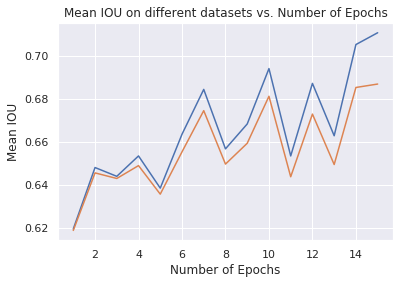

In [39]:
# training_miou=[0.6194,0.6480,0.6439,0.6534,0.6384,0.6635,0.6844,0.6567,0.6683,0.6941,0.6534,0.6872,0.6628,0.7053,0.7108]
# epochs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

pdnumsqr= pd.DataFrame.from_dict([training_miou, epochs],columns=['Training dataset Mean IOU', 'Number of Epochs'])

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

  
import seaborn as sns
import pandas as pd
import numpy as np

# Training loss plot 
epochs = np.array(epochs)
training_loss = np.array(training_miou)

# # convert to pandas dataframe
# d = {'Number of Epochs': epochs, 'Training dataset Mean IOU': training_miou}
# pdnumsqr = pd.DataFrame(d)


sns.set(style='darkgrid')
sns.lineplot(x='Number of Epochs', y='Training dataset Mean IOU', data=pdnumsqr,
             markers=True, dashes=True).set_title("Training dataset Mean IOU vs. Number of Epochs")

validation_miou=[0.6187,0.6455,0.6429,0.6489,0.6356,0.6553,0.6745,0.6496,0.6593,0.6812,0.6437,0.6729,0.6494,0.6853,0.6869]

# Validation loss plot 
epochs = np.array(epochs)
validation_miou = np.array(validation_miou)

# convert to pandas dataframe
d=0
pdnumsqr= pd.DataFrame.from_dict([validation_miou, epochs],columns=['Mean IOU','Number of Epochs'])
# d = {'Number of Epochs': epochs, 'Mean IOU': validation_miou}
# pdnumsqr = pd.DataFrame(d)


sns.set(style='darkgrid')
sns.lineplot(x='Number of Epochs', y='Mean IOU', data=pdnumsqr,
             markers=["o", "x"]).set_title("Mean IOU on different datasets vs. Number of Epochs")

# Blue- Training set
# Red- Validation set

plt.show()

## Visualization of model predictions

In [22]:
# Loading the best model - Model at the 15th epoch
model=load_model('lane_detector_model_UNet_1+1+1+1+1+1+1+1+1+1+1+1+1+1+1epochs_try_softmax1903.h5')

In [14]:
test_miou=mean_iou(model,'data/test/raw/','data/test/mask/')
test_miou

0.6935706186693277

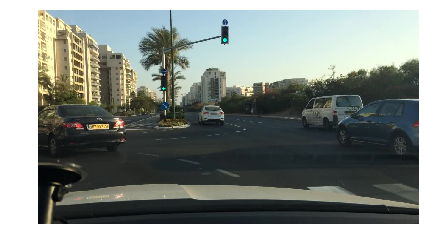

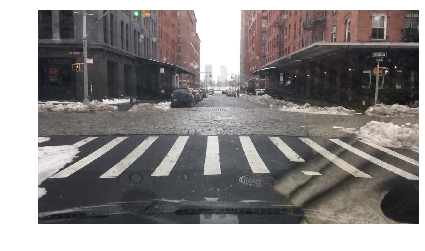

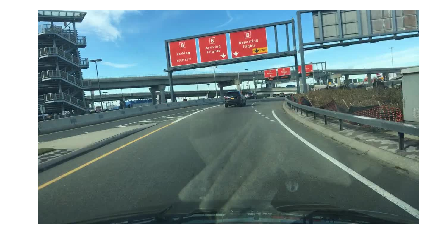

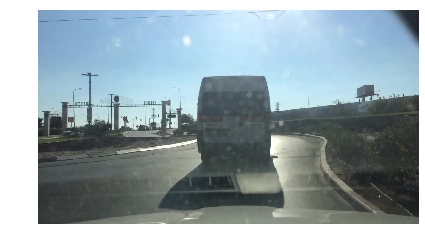

In [23]:
plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
img=cv2.imread(jpg_train[jpg_train.index('/home/maharshi.t25/val/'+'b2a5baf7-58519386.jpg')])[:,:,::-1]
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(2,2,2)
img=cv2.imread(jpg_train[jpg_train.index('/home/maharshi.t25/val/'+'b1d0a191-5490450b.jpg')])[:,:,::-1]
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(2,2,3)
img=cv2.imread(jpg_train[jpg_train.index('/home/maharshi.t25/val/'+'b2d22b2f-91d0af18.jpg')])[:,:,::-1]
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(2,2,4)
img=cv2.imread(jpg_train[jpg_train.index('/home/maharshi.t25/val/'+'b1d7b3ac-5af8623b.jpg')])[:,:,::-1]
plt.imshow(img)
plt.axis('off')
plt.show()

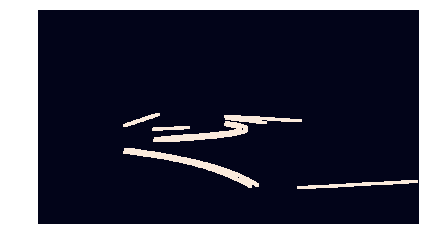

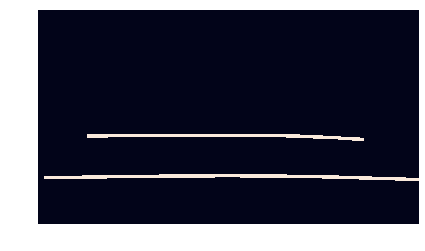

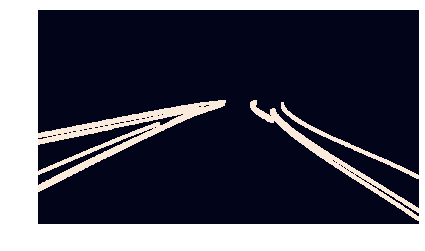

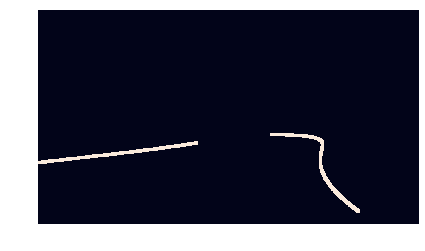

In [24]:
str1='/jet/prs/workspace/Maharshi_Assignment3/Maharshi_Data/Mask_data/'
str3='.png'
plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
img=cv2.imread(str1+'b2a5baf7-58519386.jpg'+str3)[:,:,0]
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(2,2,2)
img=cv2.imread(str1+'b1d0a191-5490450b.jpg'+str3)[:,:,0]
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(2,2,3)
img=cv2.imread(str1+'b2d22b2f-91d0af18.jpg'+str3)[:,:,0]
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(2,2,4)
img=cv2.imread(str1+'b1d7b3ac-5af8623b.jpg'+str3)[:,:,0]
plt.imshow(img)
plt.axis('off')
plt.show()

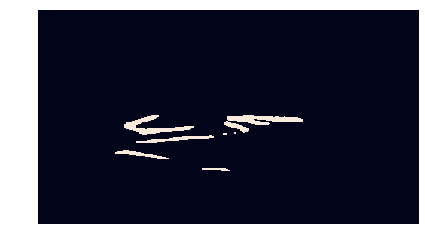

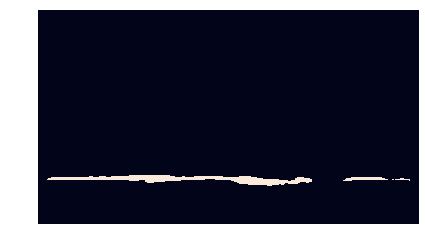

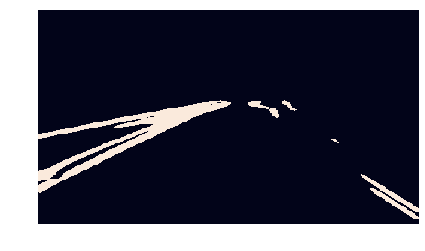

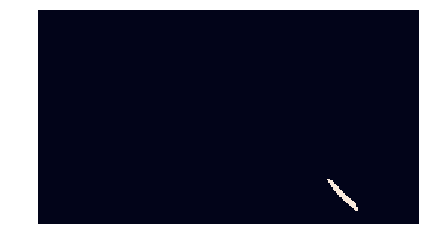

In [25]:
# Predictions of these images
plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
img=cv2.imread(jpg_train[jpg_train.index('/home/maharshi.t25/val/'+'b2a5baf7-58519386.jpg')])[:,:,::-1]
img=cv2.resize(img,dsize=(256,256),interpolation=cv2.INTER_NEAREST)
img=(img/255.).astype(np.float32)
plt.imshow(cv2.resize(model.predict(img[np.newaxis,:,:,:])[0].argmax(axis=2),dsize=(1280,720),
                      interpolation=cv2.INTER_NEAREST))
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
img=cv2.imread(jpg_train[jpg_train.index('/home/maharshi.t25/val/'+'b1d0a191-5490450b.jpg')])[:,:,::-1]
img=cv2.resize(img,dsize=(256,256),interpolation=cv2.INTER_NEAREST)
img=(img/255.).astype(np.float32)
plt.imshow(cv2.resize(model.predict(img[np.newaxis,:,:,:])[0].argmax(axis=2),dsize=(1280,720),
                      interpolation=cv2.INTER_NEAREST))
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
img=cv2.imread(jpg_train[jpg_train.index('/home/maharshi.t25/val/'+'b2d22b2f-91d0af18.jpg')])[:,:,::-1]
img=cv2.resize(img,dsize=(256,256),interpolation=cv2.INTER_NEAREST)
img=(img/255.).astype(np.float32)
plt.imshow(cv2.resize(model.predict(img[np.newaxis,:,:,:])[0].argmax(axis=2),dsize=(1280,720),
                      interpolation=cv2.INTER_NEAREST))
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
img=cv2.imread(jpg_train[jpg_train.index('/home/maharshi.t25/val/'+'b1d7b3ac-5af8623b.jpg')])[:,:,::-1]
img=cv2.resize(img,dsize=(256,256),interpolation=cv2.INTER_NEAREST)
img=(img/255.).astype(np.float32)
plt.imshow(cv2.resize(model.predict(img[np.newaxis,:,:,:])[0].argmax(axis=2),dsize=(1280,720),
                      interpolation=cv2.INTER_NEAREST))
plt.axis('off')
plt.show()

Some more visualizations

In [95]:
generator_object=custom_data_generator("data/test/raw/","data/test/mask/",1)
b,c=next(generator_object)

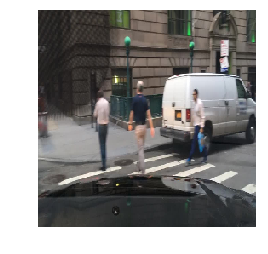

In [96]:
plt.axis('off')
plt.imshow(b[0])

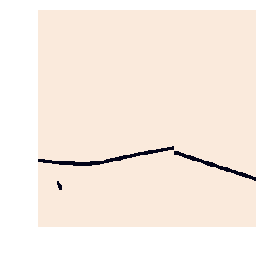

In [97]:
plt.axis('off')
plt.imshow(c[0][:,:,0])

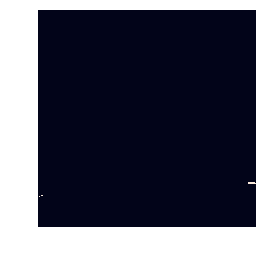

In [98]:
plt.axis('off')
plt.imshow(model.predict(b[:,:,:])[0].argmax(axis=2))

In [103]:
generator_object=custom_data_generator("data/validation/raw/","data/validation/mask/",1)
b,c=next(generator_object)

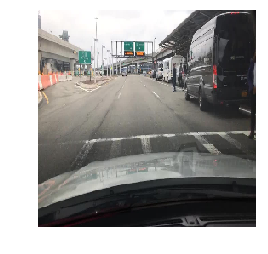

In [104]:
plt.axis('off')
plt.imshow(b[0])

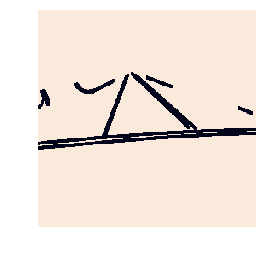

In [105]:
plt.axis('off')
plt.imshow(c[0][:,:,0])

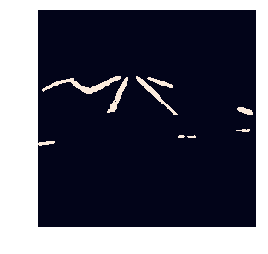

In [106]:
plt.axis('off')
plt.imshow(model.predict(b[:,:,:])[0].argmax(axis=2))

## This is not used to generate the report: Binary loss with sigmoid earlier version

In [41]:
history1=model.fit_generator(generator=generator_object,steps_per_epoch=7000,
                             epochs=3,validation_data=valid_generator_object,validation_steps=1500)

model.save('lane_detector_model_UNet_3epochs_try_sigmoid.h5')

Epoch 1/3
7000/7000 [==============================] - 633s 90ms/step - loss: 0.0851 - acc: 0.9719 - val_loss: 0.0778 - val_acc: 0.9759
Epoch 2/3
7000/7000 [==============================] - 622s 89ms/step - loss: 0.0650 - acc: 0.9767 - val_loss: 0.0731 - val_acc: 0.9752
Epoch 3/3
7000/7000 [==============================] - 623s 89ms/step - loss: 0.0577 - acc: 0.9785 - val_loss: 0.0740 - val_acc: 0.9775


In [79]:
history2=model.fit_generator(generator=generator_object,steps_per_epoch=7000,
                             epochs=2,validation_data=valid_generator_object,validation_steps=1500)

model.save('lane_detector_model_UNet_3+2epochs_try_sigmoid.h5')

Epoch 1/2
7000/7000 [==============================] - 632s 90ms/step - loss: 0.0527 - acc: 0.9799 - val_loss: 0.0705 - val_acc: 0.9784
Epoch 2/2
7000/7000 [==============================] - 627s 90ms/step - loss: 0.0492 - acc: 0.9811 - val_loss: 0.0588 - val_acc: 0.9799


In [80]:
history3=model.fit_generator(generator=generator_object,steps_per_epoch=7000,
                             epochs=2,validation_data=valid_generator_object,validation_steps=1500)

model.save('lane_detector_model_UNet_3+2+2epochs_try_sigmoid.h5')

Epoch 1/2
7000/7000 [==============================] - 627s 90ms/step - loss: 0.0467 - acc: 0.9819 - val_loss: 0.0684 - val_acc: 0.9785
Epoch 2/2
7000/7000 [==============================] - 627s 90ms/step - loss: 0.0450 - acc: 0.9822 - val_loss: 0.0778 - val_acc: 0.9785


In [81]:
history4=model.fit_generator(generator=generator_object,steps_per_epoch=7000,
                             epochs=1,validation_data=valid_generator_object,validation_steps=1500)

model.save('lane_detector_model_UNet_3+2+2+1epochs_try_sigmoid.h5')

Epoch 1/1
7000/7000 [==============================] - 628s 90ms/step - loss: 0.0425 - acc: 0.9831 - val_loss: 0.0617 - val_acc: 0.9804


In [82]:
history5=model.fit_generator(generator=generator_object,steps_per_epoch=7000,
                             epochs=1,validation_data=valid_generator_object,validation_steps=1500)

model.save('lane_detector_model_UNet_3+2+2+1+1epochs_try_sigmoid.h5')

Epoch 1/1
7000/7000 [==============================] - 627s 90ms/step - loss: 0.0407 - acc: 0.9837 - val_loss: 0.0731 - val_acc: 0.9805


In [83]:
history6=model.fit_generator(generator=generator_object,steps_per_epoch=7000,
                             epochs=1,validation_data=valid_generator_object,validation_steps=1500)

model.save('lane_detector_model_UNet_3+2+2+1+1+1epochs_try_sigmoid.h5')

Epoch 1/1
7000/7000 [==============================] - 628s 90ms/step - loss: 0.0395 - acc: 0.9840 - val_loss: 0.0700 - val_acc: 0.9786


In [9]:
history7=model.fit_generator(generator=generator_object,steps_per_epoch=7000,
                             epochs=1,validation_data=valid_generator_object,validation_steps=1500)

model.save('lane_detector_model_UNet_3+2+2+1+1+1+1epochs_try_sigmoid.h5')

Epoch 1/1
7000/7000 [==============================] - 618s 88ms/step - loss: 0.0381 - acc: 0.9845 - val_loss: 0.0640 - val_acc: 0.9806


In [10]:
history8=model.fit_generator(generator=generator_object,steps_per_epoch=7000,
                             epochs=1,validation_data=valid_generator_object,validation_steps=1500)

model.save('lane_detector_model_UNet_3+2+2+1+1+1+1+1epochs_try_sigmoid.h5')

Epoch 1/1
7000/7000 [==============================] - 613s 88ms/step - loss: 0.0368 - acc: 0.9849 - val_loss: 0.0775 - val_acc: 0.9799


In [11]:
history9=model.fit_generator(generator=generator_object,steps_per_epoch=7000,
                             epochs=1,validation_data=valid_generator_object,validation_steps=1500)

model.save('lane_detector_model_UNet_3+2+2+1+1+1+1+1+1epochs_try_sigmoid.h5')

Epoch 1/1
7000/7000 [==============================] - 614s 88ms/step - loss: 0.0350 - acc: 0.9856 - val_loss: 0.0665 - val_acc: 0.9811


In [12]:
history10=model.fit_generator(generator=generator_object,steps_per_epoch=7000,
                             epochs=1,validation_data=valid_generator_object,validation_steps=1500)

model.save('lane_detector_model_UNet_3+2+2+1+1+1+1+1+1+1epochs_try_sigmoid.h5')

Epoch 1/1
7000/7000 [==============================] - 614s 88ms/step - loss: 0.0339 - acc: 0.9859 - val_loss: 0.0720 - val_acc: 0.9805


## End of the notebook